In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import numpy as np
import tensorflow as tf
from gantools import data
from gantools import utils
from gantools import plot
from gantools.model import WGAN, CosmoWGAN
from gantools.gansystem import GANsystem, PaulinaGANsystem
from gantools.data import fmap
from gantools import evaluation
import functools
import matplotlib.pyplot as plt
from copy import deepcopy

/home/sandro/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Parameters

In [18]:
ns = 256 # Resolution of the image
try_resume = False # Try to resume previous simulation
Mpch = 70 # Type of dataset (select 70 or 350)


forward = fmap.stat_forward
backward = fmap.stat_backward
def non_lin(x):
    return tf.nn.tanh(x)

# Data handling

Load the data

In [4]:
dataset = data.load.load_nbody_dataset(nsamples=None, spix=ns, Mpch=Mpch, forward_map=forward)

Select 1 samples out of 10.
images shape =  (1, 256, 256, 256)


In [5]:
# The dataset can return an iterator.
it = dataset.iter(10)
print(next(it).shape)
del it

(10, 256, 256, 1)


In [6]:
# Get all the data
X = dataset.get_all_data().flatten()

In [7]:
# Check that the backward maps invert the forward map.
assert(np.sum(np.abs(forward(backward(X))-X))< 5)
# # For debugging
# np.sum(np.abs(forward(backward(X))-X))
# forward(backward(X))-X
# x = np.arange(1e4)
# plt.plot(x, backward(forward(x))-x)

Display the histogram of the pixel densities after the forward map

min: 0.0
max: 3.437527656555176


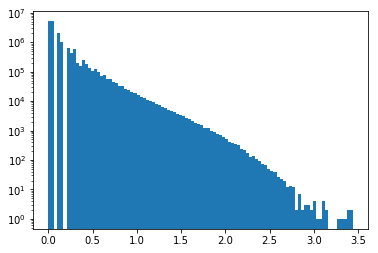

In [8]:
plt.hist(X, 100)
print('min: {}'.format(np.min(X)))
print('max: {}'.format(np.max(X)))
plt.yscale('log')

In [9]:
# to free some memory
del X

Let us plot 16 images

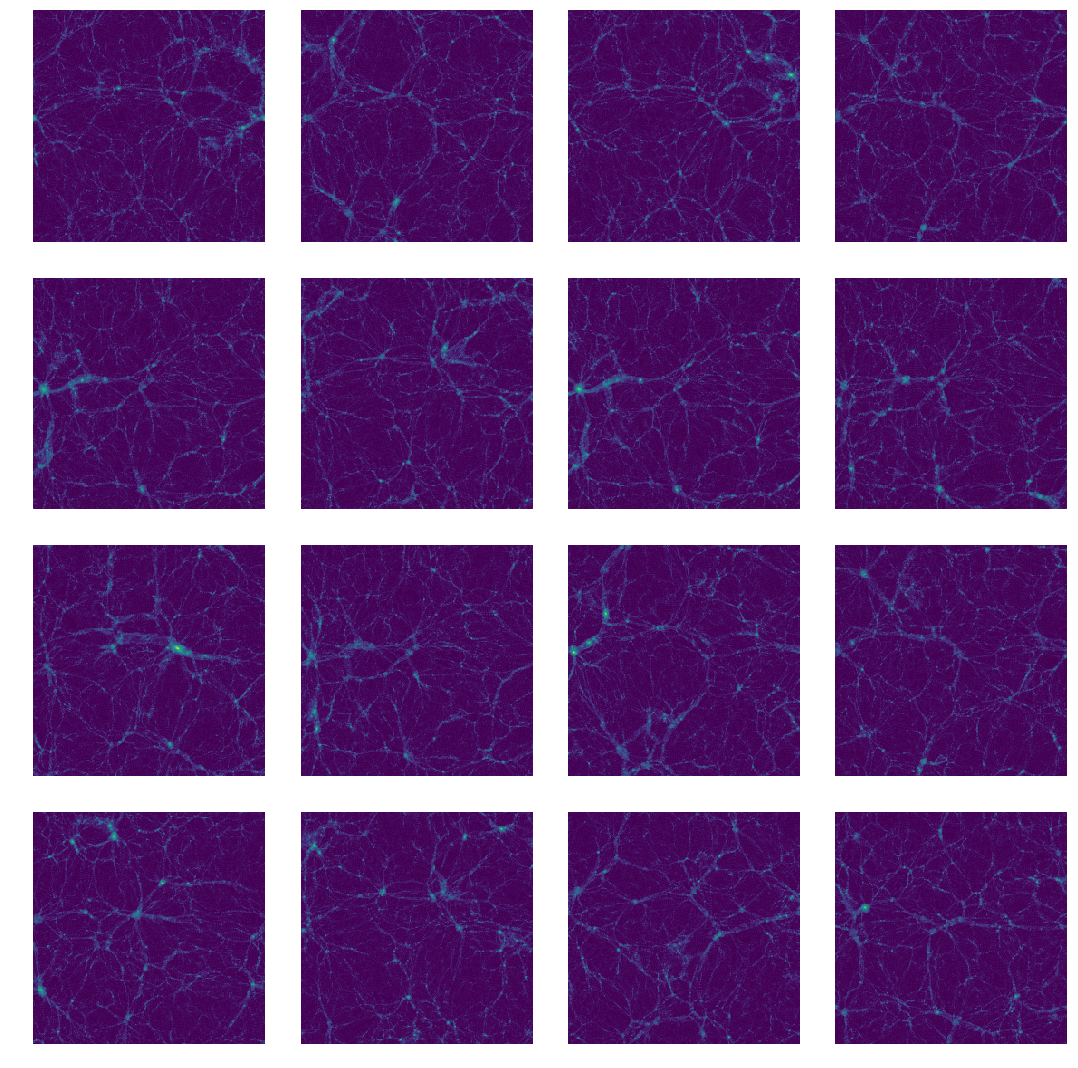

In [10]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(15,15))
idx = 0
imgs = dataset.get_samples(N=16)[:, :, :, 0]
for row in ax:
    for col in row:
        col.imshow(imgs[idx], vmin=0, vmax=np.max(imgs))
        col.axis('off')
        idx = idx + 1
fig.tight_layout()

# Define parameters for the WGAN

In [11]:
time_str = '2D'
global_path = 'saved_results'

name = 'WGAN{}'.format(ns) + '_paper_70_Mpch' + time_str

## Parameters

In [19]:
bn = True

params_discriminator = dict()
params_discriminator['stride'] = [2, 2, 2, 2]
params_discriminator['nfilter'] = [64, 128, 256, 512]
params_discriminator['shape'] = [[5, 5],[5, 5], [5, 5], [5, 5]]
params_discriminator['batch_norm'] = [bn, bn, bn, bn]
params_discriminator['full'] = []
params_discriminator['minibatch_reg'] = False
params_discriminator['summary'] = True
params_discriminator['data_size'] = 2

params_generator = dict()
params_generator['stride'] = [2, 2, 2, 2]
params_generator['latent_dim'] = 100
params_generator['nfilter'] = [256, 128, 64, 1]
params_generator['shape'] = [[5, 5], [5, 5], [5, 5], [5, 5]]
params_generator['batch_norm'] = [bn, bn, bn]
params_generator['full'] = [16 * 16 * 512]
params_generator['summary'] = True
params_generator['non_lin'] = non_lin
params_generator['data_size'] = 2

params_optimization = dict()
params_optimization['optimizer'] = 'adam'
params_optimization['batch_size'] = 16
params_optimization['epoch'] = 5
params_optimization['learning_rate'] = 1e-5
params_optimization['beta1'] = 0.5
params_optimization['beta2'] = 0.999
params_optimization['epsilon'] = 1e-8

# Cosmology parameters
params_cosmology = dict()
params_cosmology['forward_map'] = forward
params_cosmology['backward_map'] = backward

# all parameters
params = dict()
params['net'] = dict() # All the parameters for the model
params['net']['generator'] = params_generator
params['net']['discriminator'] = params_discriminator
params['net']['cosmology'] = params_cosmology # Parameters for the cosmological summaries
params['net']['prior_distribution'] = 'gaussian'
params['net']['shape'] = [ns, ns, 1] # Shape of the image
params['net']['gamma_gp'] = 1000 # Gradient penalty

params['optimization'] = params_optimization
params['summary_every'] = 1 # Tensorboard summaries every ** iterations
params['print_every'] = 1 # Console summaries every ** iterations
params['save_every'] = 1000 # Save the model every ** iterations
params['summary_dir'] = os.path.join(global_path, name +'_summary/')
params['save_dir'] = os.path.join(global_path, name + '_checkpoints/')
params['Nstats'] = 200

In [20]:
resume, params = utils.test_resume(try_resume, params)
# If a model is reloaded and some parameters have to be changed, then it should be done here.
# For example, setting the number of epoch to 5 would be:
params['optimization']['epoch'] = 1


# Build the model

In [ ]:
wgan = PaulinaGANsystem(CosmoWGAN, params)

Generator 
--------------------------------------------------
     The input is of size (?, 100)
     0 Full layer with 131072 outputs
         Size of the variables: (?, 131072)
     Reshape to (?, 16, 16, 512)
     1 Deconv layer with 256 channels
         Batch norm
         Non linearity applied
         Size of the variables: (?, 32, 32, 256)
     2 Deconv layer with 128 channels
         Batch norm
         Non linearity applied
         Size of the variables: (?, 64, 64, 128)
     3 Deconv layer with 64 channels
         Batch norm
         Non linearity applied
         Size of the variables: (?, 128, 128, 64)
     4 Deconv layer with 1 channels
         Size of the variables: (?, 256, 256, 1)
    Costum non linearity: <function non_lin at 0x7f4d0021ed08>
     The output is of size (?, 256, 256, 1)
--------------------------------------------------

Discriminator 
--------------------------------------------------
     The input is of size (?, 256, 256, 1)
     0 Conv layer wit

# Train the model

In [ ]:
wgan.train(dataset, resume=resume)

Compute real statistics: descriptives/mean_l2
Compute real statistics: descriptives/var_l2
Compute real statistics: descriptives/min_l2
Compute real statistics: descriptives/max_l2
Compute real statistics: descriptives/kurtosis_l2
Compute real statistics: descriptives/skewness_l2
Compute real statistics: descriptives/median_l2
Compute real statistics: cosmology/mass_histogram_l2log
Compute real statistics: cosmology/peak_histogram_l2log
Compute real statistics: cosmology/psd_l2log
Compute real statistics: final/mass_histogram_l2
Compute real statistics: final/peak_histogram_l2
Compute real statistics: final/psd_l2log
Compute real statistics: wasserstein/mass_histogram_l2
Compute real statistics: wasserstein/psd_l2
Erase recursively directory: saved_results/WGAN256_paper_2D_summary/
Erase recursively directory: saved_results/WGAN256_paper_2D_checkpoints/
Start training
 * Epoch: [ 0] [   1/  16] Counter: 1	( 5.9 min	0.045 examples/sec	351.75 sec/batch)
   Disc batch loss:101946.45312500

# Generate new samples
To have meaningful statistics, be sure to generate enough samples
* 2000 : 32 x 32
* 500 : 64 x 64
* 200 : 128 x 128


In [ ]:
N = 2000 # Number of samples
gen_sample = np.squeeze(wgan.generate(N=N))

Display a few fake samples

In [ ]:
plt.figure(figsize=(15,15))
plot.draw_images(gen_sample,nx=4,ny=4);
plt.title("Fake samples");

# Evaluation of the sample quality

In [ ]:
# Before computing the statistics, we need to invert the mapping
raw_images = backward(dataset.get_samples(dataset.N))
gen_sample_raw = backward(gen_sample)

In [ ]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_psd(raw_images, gen_sample_raw)

In [ ]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_peak_cout(raw_images, gen_sample_raw)

In [ ]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_mass_hist(raw_images, gen_sample_raw)